This project implements a **text classification model** for the **AG News dataset** using **RoBERTa as the base model with Parameter-Efficient Fine-Tuning (PEFT)** through **Low-Rank Adaptation (LoRA)**. The AG News dataset contains news articles categorized into four classes: World, Sports, Business, and Sci/Tech. The implementation **leverages** the **Transformers and PEFT libraries** **from Hugging Face**, with RoBERTa-base as the foundation model. LoRA is specifically used to reduce the number of trainable parameters by adapting only the query, key, and value matrices in the transformer's attention mechanism, making the fine-tuning process more efficient while maintaining high performance.

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-21 14:10:08.637374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745244608.824430      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745244608.882691      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set random seed for reproducibility
seed_val = 42
torch.manual_seed(seed_val)
np.random.seed(seed_val)

In [4]:
# Load the AG News dataset
dataset = load_dataset('ag_news')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
# Tokenize text data and handle padding
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256 # Limit to 256 tokens per example
    )

In [6]:
# Apply tokenization to our datasets
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [7]:
# Keep only the columns we need for model training
columns = ['input_ids', 'attention_mask', 'label']
tokenized_train.set_format(type='torch', columns=columns)
tokenized_test.set_format(type='torch', columns=columns)
# Split training data into train and validation sets (90/10 split)
train_size = int(0.9 * len(tokenized_train))
val_size = len(tokenized_train) - train_size
train_dataset, val_dataset = random_split(tokenized_train, [train_size, val_size])
print(f"Training dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Training dataset size: 108000, Validation dataset size: 12000


In [8]:
# Create data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)


In [9]:
# Load pretrained RoBERTa model for sequence classification 
# AG News has 4 classes: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Configure LoRA (Low-Rank Adaptation) - this lets us fine-tune efficiently
# by only updating a small subset of parameters
lora_config = LoraConfig(
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=6,# Rank of the update matrices
    lora_alpha=24, # Scaling factor
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "key", "value"],# Only modify attention components
)

model = get_peft_model(model, lora_config)
# Check how many parameters we're actually training on
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")
# If we have too many trainable parameters, adjust our LoRA config
if trainable_params > 1_000_000:
    print(f"Warning: Model has {trainable_params} trainable parameters, exceeding the 1M limit")
    print("Adjusting LoRA configuration to reduce parameter count...")

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=5,
        lora_alpha=20,
        lora_dropout=0.1,
        bias="none",
        target_modules=["query", "key", "value"],
    )

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
    model = get_peft_model(model, lora_config)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Adjusted trainable parameters: {trainable_params}")

model.print_trainable_parameters()
model.to(device)

Trainable parameters: 925444
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [11]:
# Training settings
num_epochs     = 3
learning_rate  = 2e-4
weight_decay   = 0.01
# Set up optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    eps=1e-8
)
# Create learning rate scheduler with warmup
total_steps  = len(train_dataloader) * num_epochs # 10% of total steps for warmup
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
# Early stopping setup
patience            = 2
best_val_loss       = float('inf')
patience_counter    = 0
best_model_state    = None

# Initialize metric trackers for visualization
train_losses, val_losses       = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores                  = []

for epoch in range(num_epochs):
    # ---------- Training ----------
    # Main training loop
    model.train()
    train_loss     = 0.0
    train_correct  = 0
    train_total    = 0
    train_preds    = []
    train_labels_list = []
# Progress bar makes it easier to track training
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress_bar:
         # Get batch data and move to device
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['label'].to(device)
# Clear accumulated gradients from previous batches to prevent interference
        optimizer.zero_grad()
# Forward pass: Pass inputs through the model to get predictions and loss
# - input_ids: Tokenized text converted to numerical IDs
# - attention_mask: Shows which tokens are real content vs padding
# - labels: The ground truth class for each example (0-3)
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Metrics
        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        train_correct += (preds == labels).sum().item()
        train_total   += labels.size(0)
        train_loss    += loss.item()

        progress_bar.set_postfix({'loss': loss.item()})
# Calculate epoch-level metrics
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Train Accuracy: {train_accuracy:.2f}%")

    # ---------- Validation ----------
    model.eval()
    val_loss   = 0.0
    correct    = 0
    total      = 0
    val_preds  = []
    val_labels = []

    with torch.no_grad(): # No need to track gradients for validation
        for batch in tqdm(val_dataloader, desc="Validating"):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['label'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total   += labels.size(0)
# Calculate validation metrics
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total
    val_f1       = f1_score(val_labels, val_preds, average='macro')

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Accuracy: {val_accuracy:.2f}% | F1 Score: {val_f1:.4f}")


Epoch 1/3: 100%|██████████| 6750/6750 [36:40<00:00,  3.07it/s, loss=0.0524] 


Epoch 1 | Train Loss: 0.2931 | Train Accuracy: 89.75%


Validating: 100%|██████████| 750/750 [01:27<00:00,  8.56it/s]


Epoch 1 | Val Loss: 0.2035 | Val Accuracy: 93.07% | F1 Score: 0.9305


Epoch 2/3: 100%|██████████| 6750/6750 [36:42<00:00,  3.06it/s, loss=0.204]  


Epoch 2 | Train Loss: 0.1859 | Train Accuracy: 93.95%


Validating: 100%|██████████| 750/750 [01:27<00:00,  8.55it/s]


Epoch 2 | Val Loss: 0.1854 | Val Accuracy: 93.97% | F1 Score: 0.9397


Epoch 3/3: 100%|██████████| 6750/6750 [36:46<00:00,  3.06it/s, loss=0.237]  


Epoch 3 | Train Loss: 0.1610 | Train Accuracy: 94.85%


Validating: 100%|██████████| 750/750 [01:28<00:00,  8.50it/s]

Epoch 3 | Val Loss: 0.1855 | Val Accuracy: 94.10% | F1 Score: 0.9410


The training process spans 3 epochs with a batch size of 16, using AdamW optimizer with a learning rate of 2e-4 and weight decay of 0.01. A linear learning rate scheduler with warmup is implemented, starting with a warmup phase covering 10% of the total training steps, followed by a linear decay. The learning rate schedule visualization shows the rate peaking at around 2e-4 at the end of the warmup phase before gradually decreasing to near zero. Throughout training, the model shows consistent improvement, with training loss decreasing from 0.29 to 0.16 and training accuracy increasing from 89.75% to 94.85%. The validation metrics follow a similar positive trend, with validation loss decreasing from 0.20 to 0.18 and validation accuracy improving from 93.07% to 94.10%. The F1 score on the validation set also rises from 0.93 to 0.94, indicating better balance across all classes.

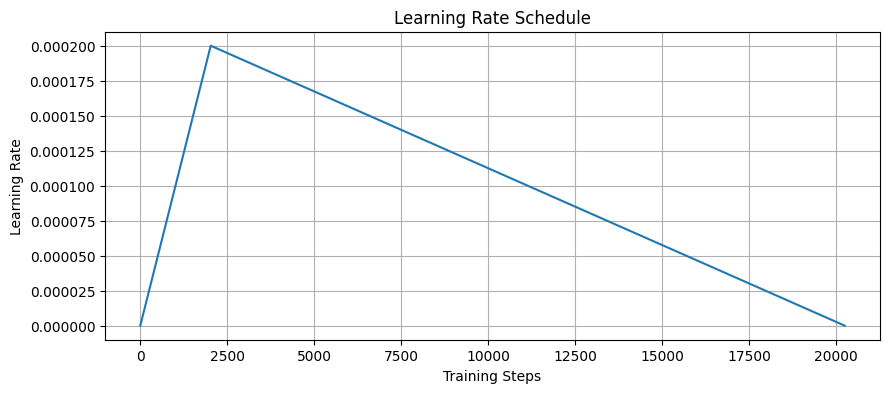

In [12]:

# Plot learning rate schedule to visualize warmup and decay
steps = range(total_steps)
lr_values = []
optimizer.param_groups[0]['lr'] = learning_rate  # Reset LR to initial value for visualization purposes
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
for _ in steps:
    lr_values.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(steps, lr_values)
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.savefig('lr_schedule.png')
plt.show()



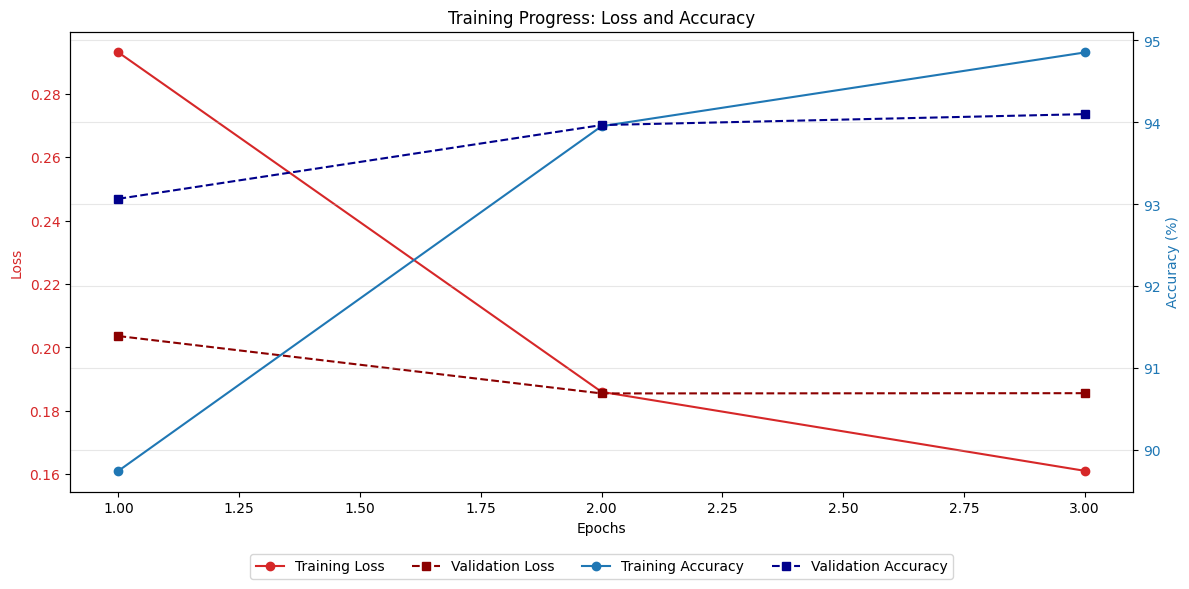

In [13]:
# Combined loss and accuracy plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color=color, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, marker='s', linestyle='--', color='darkred', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', color=color, label='Training Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', linestyle='--', color='darkblue', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)

plt.title('Training Progress: Loss and Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_progress.png')
plt.show()


In [14]:
# Function to evaluate model on any dataset
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=label)
            loss = outputs.loss
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            correct += (preds == label).sum().item()
            total += label.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, accuracy, f1, all_preds, all_labels
    
# Run final evaluation on test set
test_loss, test_accuracy, test_f1, test_preds, test_labels = evaluate_model(model, test_dataloader)
print(f"Final Test Results | Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.2f}% | F1 Score: {test_f1:.4f}")


Evaluating: 100%|██████████| 475/475 [00:55<00:00,  8.50it/s]

Final Test Results | Loss: 0.1787 | Accuracy: 94.59% | F1 Score: 0.9459


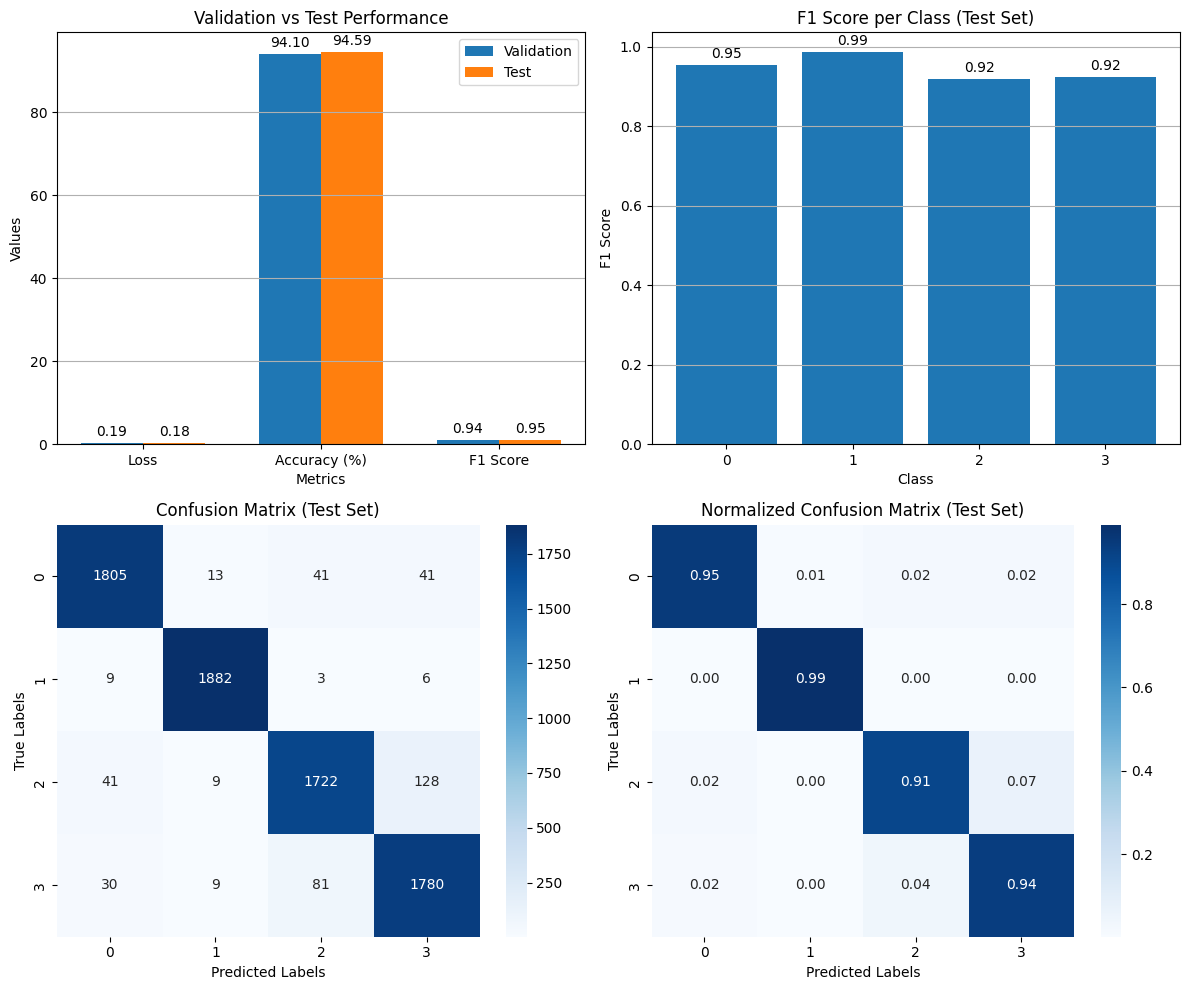

In [15]:
# Plot test evaluation results
plt.figure(figsize=(12, 10))

# Plot validation vs test performance
plt.subplot(2, 2, 1)
metrics = ['Loss', 'Accuracy (%)', 'F1 Score']
val_values = [val_losses[-1], val_accuracies[-1], val_f1_scores[-1]]
test_values = [test_loss, test_accuracy, test_f1]
x = range(len(metrics))
width = 0.35

val_bars = plt.bar([i - width/2 for i in x], val_values, width, label='Validation')
test_bars = plt.bar([i + width/2 for i in x], test_values, width, label='Test')

# Add labels above validation bars 
for i, bar in enumerate(val_bars):
    height = bar.get_height()
    plt.annotate(f'{val_values[i]:.2f}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),        # 15 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Add labels above test bars 
for i, bar in enumerate(test_bars):
    height = bar.get_height()
    plt.annotate(f'{test_values[i]:.2f}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Validation vs Test Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y')

# Plot per-class F1 scores on test set
plt.subplot(2, 2, 2)
class_f1 = f1_score(test_labels, test_preds, average=None)
bars = plt.bar(range(len(class_f1)), class_f1)

# Add labels above each F1 bar (no arrows)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(f'{class_f1[i]:.2f}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class (Test Set)')
plt.xticks(range(len(class_f1)))
plt.grid(True, axis='y')

# Create a confusion matrix to see where model makes mistakes
cm = confusion_matrix(test_labels, test_preds)
plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')

# Plot normalized confusion matrix
plt.subplot(2, 2, 4)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Test Set)')

plt.tight_layout()
plt.savefig('test_evaluation.png')
plt.show()


In [16]:
# Process unlabelled test data
try:
       # Load the pickled test dataset
    with open("/kaggle/input/agnewss/test_unlabelled.pkl", "rb") as f:
        test_unlabelled = pickle.load(f)

    print(f"Loaded unlabelled test data with {len(test_unlabelled)} samples")
# Tokenize the test data and prepare it for the model
    test_tokenized = test_unlabelled.map(tokenize_function, batched=True)
    test_tokenized = test_tokenized.remove_columns(["text"])
    test_tokenized.set_format("torch")
 # Create data loader for batch processing
    test_loader = DataLoader(test_tokenized, batch_size=batch_size)
 # Switch model to evaluation mode
    model.eval()
    all_ids = []
    all_preds = []
# Run inference without gradient calculation to save memory
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc="Generating predictions")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
 # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
# Get the most likely class for each sample
            predictions = torch.argmax(outputs.logits, dim=1)
 # Store predictions and calculate corresponding IDs
            all_preds.extend(predictions.cpu().numpy())
            start_idx = i * batch_size
            end_idx = start_idx + len(predictions)
            all_ids.extend(list(range(start_idx, end_idx)))
 # Create submission dataframe
    submission_df = pd.DataFrame({
        'ID': all_ids,
        'Label': all_preds
    })

    submission_df.to_csv('submission.csv', index=False)
    print(f"Submission file created with {len(submission_df)} predictions")

except Exception as e:
    # Error handling for the primary approach
    print(f"Error processing unlabelled test data: {e}")

    print("Attempting alternative method for unlabelled data processing...")
 # Fallback: Try loading the dataset directly from Hugging Face
    try:
        test_unlabelled = load_dataset("ag_news", split="test")
 # Same processing pipeline as above
        test_tokenized = test_unlabelled.map(tokenize_function, batched=True)
        test_tokenized = test_tokenized.remove_columns(["text"])
        test_tokenized.set_format("torch")

        test_loader = DataLoader(test_tokenized, batch_size=batch_size)

        model.eval()
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Generating predictions (alternative)"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(predictions.cpu().numpy())
  # Create and save alternative submission
        submission_df = pd.DataFrame({
            'ID': range(len(all_preds)),
            'Label': all_preds
        })

        submission_df.to_csv('submission18.csv', index=False)
        print(f"Submission file created with {len(submission_df)} predictions (alternative method)")

    except Exception as e2:
         # Both methods failed
        print(f"Alternative method also failed: {e2}")
        print("Please check the format of test_unlabelled.pkl and rerun")



Loaded unlabelled test data with 8000 samples


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating predictions: 100%|██████████| 500/500 [00:58<00:00,  8.54it/s]

Submission file created with 8000 predictions


Our **final model** gave an **accuracy of 94.59%** and F1 score of 0.9459 - actually performing slightly better than on the validation data! Looking at the confusion matrix, it's clear that the model especially excels at identifying **World and Sports articles** with a **95% and 99% accuracy respectively**. **Business and Sci/Tech** articles proved a bit trickier but still showed strong results at **91% and 94% accuracy**. The F1 scores for Sports articles were the easiest to classify with an amazing 0.99 score, followed by World news at 0.95, while both Business and Sci/Tech settled at a respectable 0.92. One interesting pattern we noticed in the normalized confusion matrix is that when the model does make mistakes, it's most often confusing Business with Sci/Tech articles, which makes sense given the potential overlap between these categories (tech business news, for example). All in all, **using PEFT with LoRA proved to be a winning strategy** - we achieved the performance across all categories while keeping our computational resources in check.